<a href="https://colab.research.google.com/github/YC0429/Enefit---Predict-Energy-Behavior-of-Prosumers/blob/main/Enefit_Time_Series_Analysis_workplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workplace for Enefit - Predict Energy Behavior of Prosumers**
https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/overview


## Import necessary libraries

In [1]:
import os, glob
import json
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data sets

In [3]:
path = "drive/MyDrive/Colab Notebooks/Kaggle Related/Enefit - Predict Energy Behavior of Prosumers/data/data_source/"

### Weather forecasts that would have been available at prediction time.

In [4]:
forecast_weather_df  = pd.read_csv(path+"forecast_weather.csv")
forecast_weather_df['origin_datetime'] = pd.to_datetime(forecast_weather_df['origin_datetime'])
forecast_weather_df['forecast_datetime'] = pd.to_datetime(forecast_weather_df['forecast_datetime'])

forecast_weather_df.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [6]:
forecast_weather_df.isnull().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

### Historic weather data.

In [7]:
historical_weather_df = pd.read_csv(path+"historical_weather.csv")
historical_weather_df['datetime'] = pd.to_datetime(historical_weather_df['datetime'])

historical_weather_df.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [8]:
historical_weather_df.isnull().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64

### Remaining data

In [9]:
train_df = pd.read_csv(path+'train.csv')
gas_prices_df = pd.read_csv(path+'gas_prices.csv')
client_df = pd.read_csv(path+'client.csv')
electricity_prices_df = pd.read_csv(path+'electricity_prices.csv')

In [10]:
print("Train Data:")
print(train_df.info())

print("\nGas Prices Data:")
print(gas_prices_df.info())

print("\nClient Data:")
print(client_df.info())

print("\nElectricity Prices Data:")
print(electricity_prices_df.info())

print("\nForecast Weather Data:")
print(forecast_weather_df.info())

print("\nHistorical Weather Data:")
print(historical_weather_df.info())

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None

Gas Prices Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_

In [11]:
print("Train Data:")
print(train_df.isnull().sum())

print("\nGas Prices Data:")
print(gas_prices_df.isnull().sum())

print("\nClient Data:")
print(client_df.isnull().sum())

print("\nElectricity Prices Data:")
print(electricity_prices_df.isnull().sum())

print("\nForecast Weather Data:")
print(forecast_weather_df.isnull().sum())

print("\nHistorical Weather Data:")
print(historical_weather_df.isnull().sum())

Train Data:
county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

Gas Prices Data:
forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64

Client Data:
product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64

Electricity Prices Data:
forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

Forecast Weather Data:
latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudco

In [12]:
train_df.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


In [22]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


## EDA part

In [30]:
plt.style.use('fivethirtyeight')

### Prosumer Distribution by County

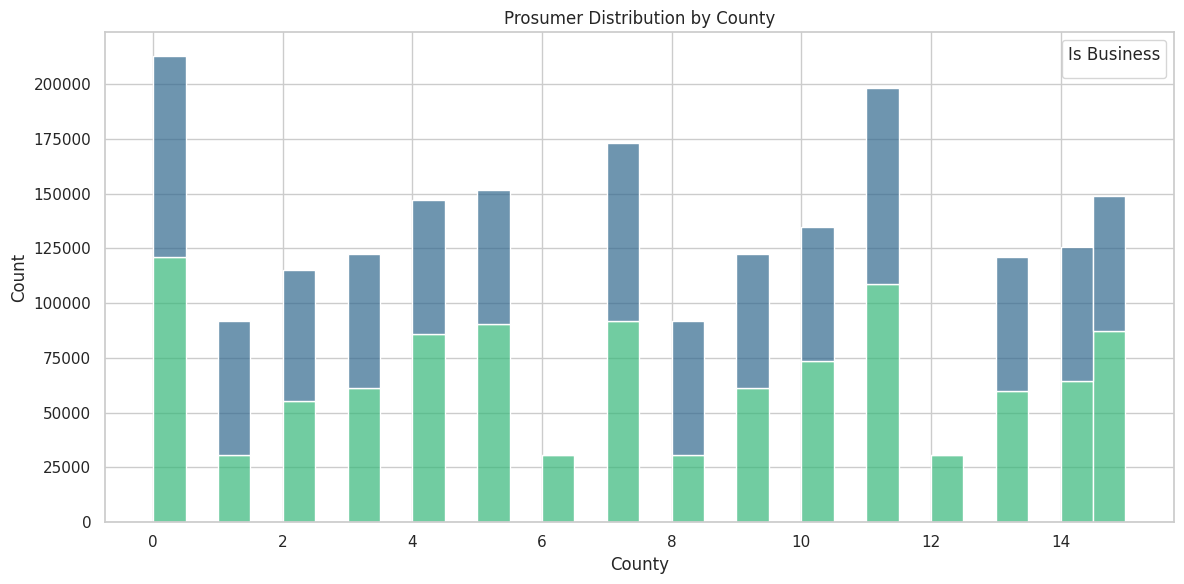

In [21]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(
    data=train_df,      # DataFrame containing the data
    x='county',        # Column to be plotted on the x-axis
    hue='is_business',    # Column to determine the color of the bars
    multiple='stack',     # Stacking bars for different categories
    bins=30,         # Number of bins (bars) in the histogram
    palette='viridis',    # Color palette
    alpha=0.7         # Transparency level of the bars
)

plt.xlabel('County')
plt.ylabel('Count')
plt.title('Prosumer Distribution by County')

plt.legend(title='Is Business', loc='upper right')

plt.tight_layout()
plt.show()

### Energy Consumption vs. Production

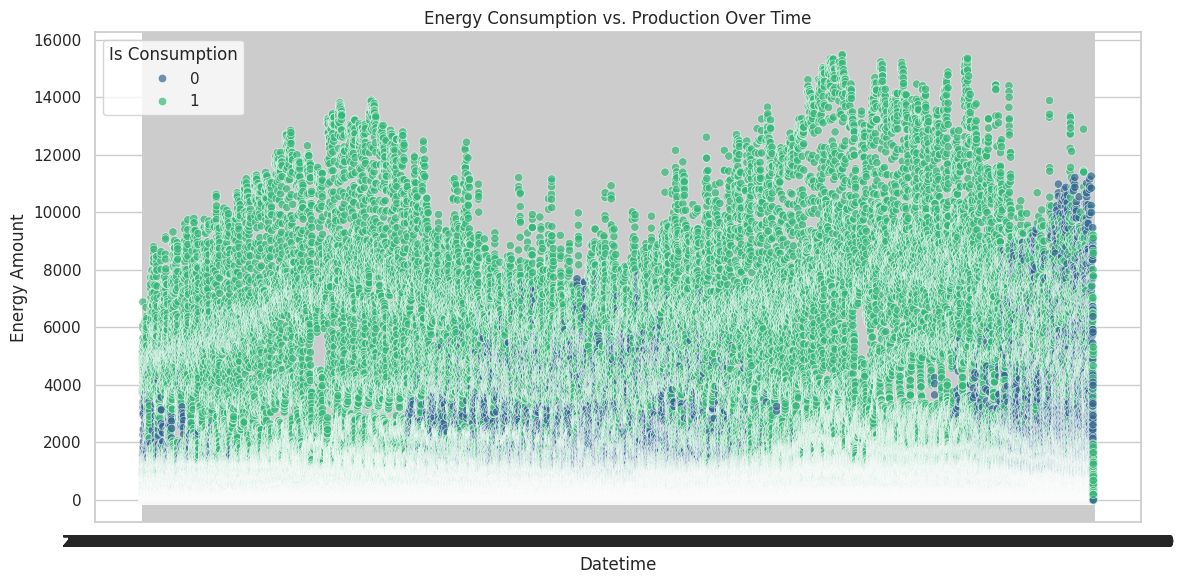

In [37]:
plt.figure(figsize=(12, 6))
energy_consumption_production = sns.scatterplot(
    data=train_df,
    x='datetime',
    y='target',
    hue='is_consumption',
    palette='viridis',  # Choose a color palette
    alpha=0.7
)

# Set the title and labels
energy_consumption_production.set_title('Energy Consumption vs. Production Over Time')
energy_consumption_production.set_xlabel('Datetime')
energy_consumption_production.set_ylabel('Energy Amount')

# Show the legend
energy_consumption_production.legend(title='Is Consumption')

# Show the plot
plt.tight_layout()
plt.show()

### Gas price overtime

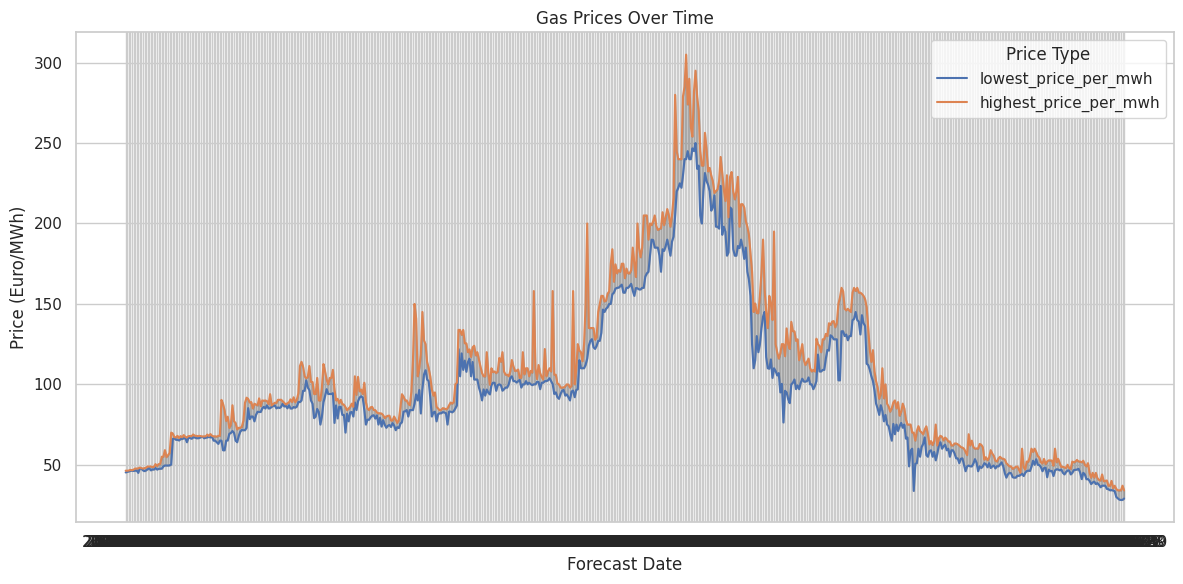

In [47]:
# Melt the DataFrame into long format
# Use pd.melt to transform the DataFrame from wide to long format.
gas_prices_long = pd.melt(gas_prices_df, id_vars=['forecast_date'], value_vars=['lowest_price_per_mwh', 'highest_price_per_mwh'],
                          var_name='Price Type', value_name='Price (Euro/MWh)')

# Create the line plot
plt.figure(figsize=(12, 6))
gas_prices_over_time = sns.lineplot(
    data=gas_prices_long,
    x='forecast_date',
    y='Price (Euro/MWh)',
    hue='Price Type'
)

# Shade the area between the two lines
plt.fill_between(gas_prices_df['forecast_date'],
                 gas_prices_df['lowest_price_per_mwh'],
                 gas_prices_df['highest_price_per_mwh'],
                 color='k',
                 alpha=.2)

# Set the title and labels
plt.title('Gas Prices Over Time')
plt.xlabel('Forecast Date')
plt.ylabel('Price (Euro/MWh)')

# Show the plot
plt.tight_layout()
plt.show()

### Installed Capacity Distribution by Product Type

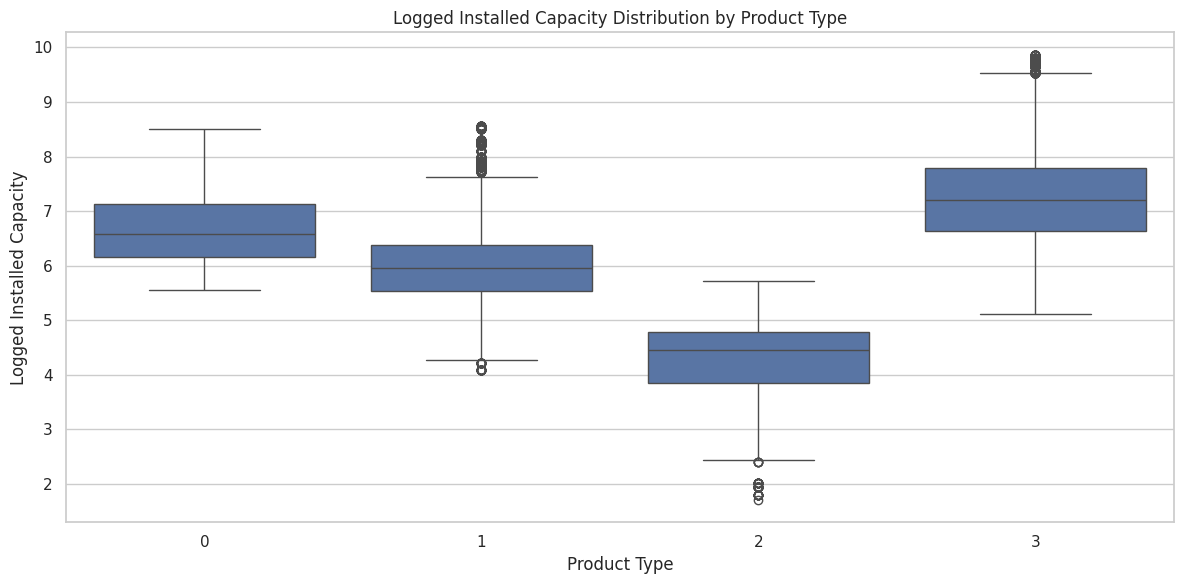

In [57]:
# Calculate the 95th percentile of installed capacity, due to the volume of observations falls out of 1.5IQR + third quantile of the boxplot
# Making the boxplot to be squeezed
# percentile_95 = client_df['installed_capacity'].quantile(0.95)

# Apply log transformation to installed capacity, due to the volume of observations falls out of 1.5IQR + third quantile of the boxplot
# Making the boxplot to be squeezed
client_df['log_installed_capacity'] = np.log(client_df['installed_capacity'])

plt.figure(figsize=(12, 6))
installed_capacity_distribution = sns.boxplot(client_df,
                        x='product_type',
                        y='log_installed_capacity',)
                        # whis=percentile_95)  # Adjust whiskers to the 95th percentile

# Set title and labels
installed_capacity_distribution.set_title('Logged Installed Capacity Distribution by Product Type')
installed_capacity_distribution.set_xlabel('Product Type')
installed_capacity_distribution.set_ylabel('Logged Installed Capacity')

# Show plot
plt.tight_layout()
plt.show()

### Electricity Price Distribution

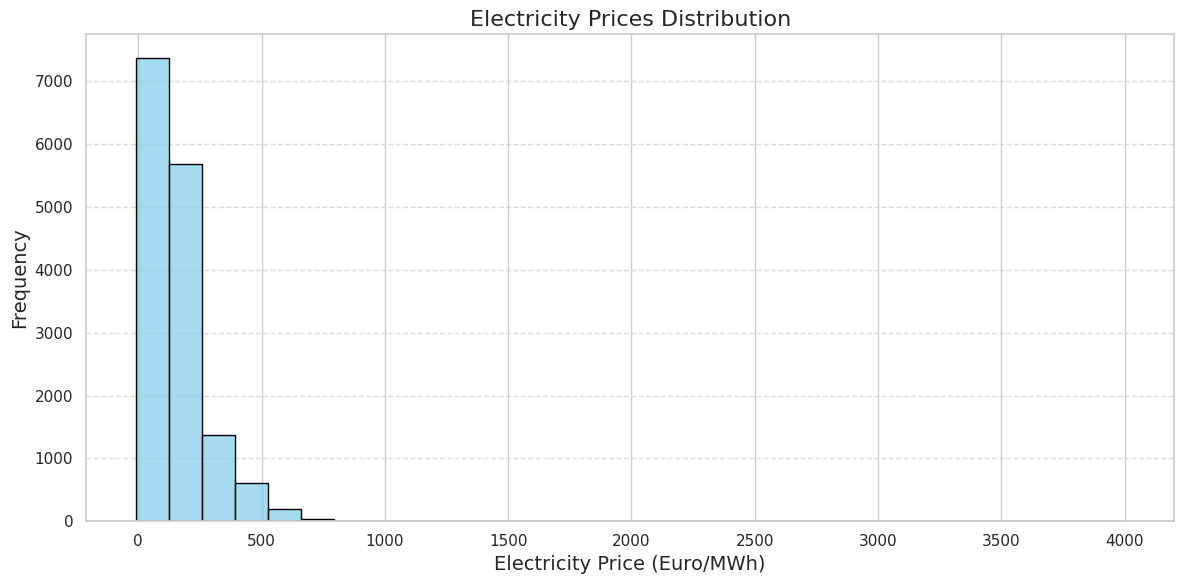

In [60]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
elec_price_distribution = sns.histplot(electricity_prices_df['euros_per_mwh'],
                     bins=30,
                     kde=False,
                     color='skyblue',
                     edgecolor='black')

elec_price_distribution.set_title('Electricity Prices Distribution', fontsize=16)
elec_price_distribution.set_xlabel('Electricity Price (Euro/MWh)', fontsize=14)
elec_price_distribution.set_ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Wind Speed Distribution

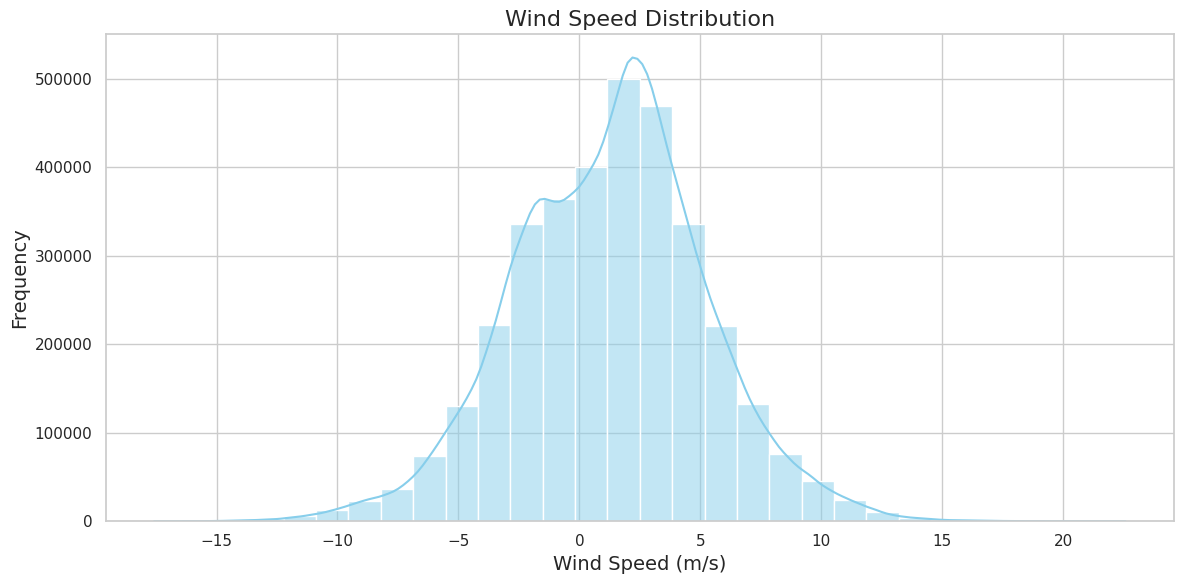

In [62]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
wind_spd_distribution = sns.histplot(forecast_weather_df['10_metre_u_wind_component'],
                    bins=30,
                    kde=True,
                    color='skyblue')

wind_spd_distribution.set_title('Wind Speed Distribution', fontsize=16)
wind_spd_distribution.set_xlabel('Wind Speed (m/s)', fontsize=14)
wind_spd_distribution.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

### Historical Rainfall Over Time

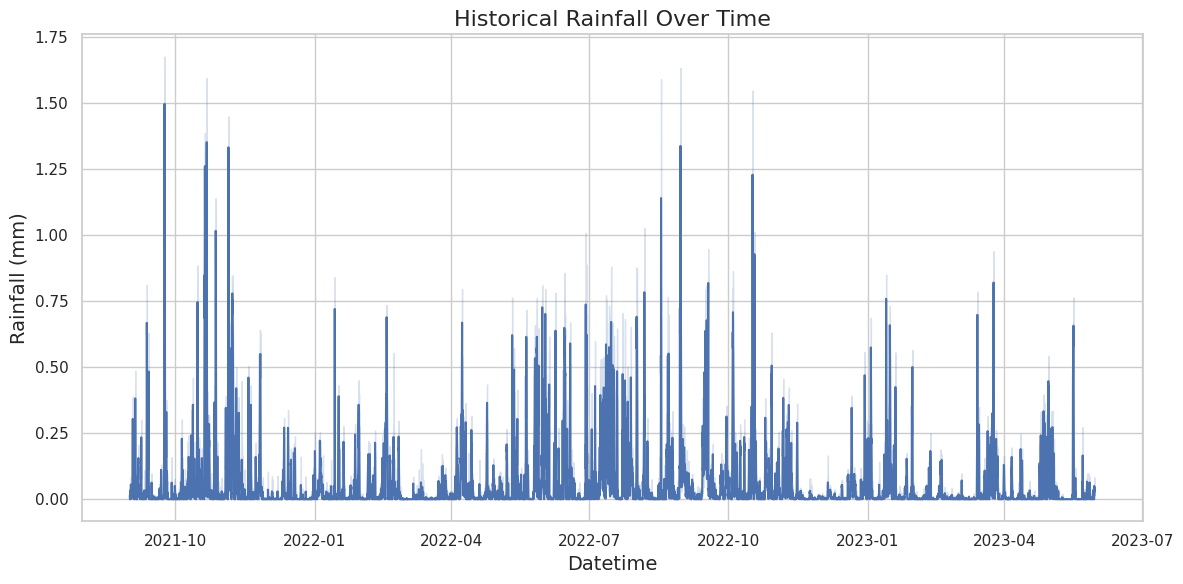

In [64]:
# Create the line plot
plt.figure(figsize=(12, 6))
historical_rainfall_over_time = sns.lineplot(
    data=historical_weather_df,
    x='datetime',
    y='rain',
)


historical_rainfall_over_time.set_title('Historical Rainfall Over Time', fontsize=16)
historical_rainfall_over_time.set_xlabel('Datetime', fontsize=14)
historical_rainfall_over_time.set_ylabel('Rainfall (mm)', fontsize=14)

plt.tight_layout()
plt.show()

### Prosumer Type Pie Chart

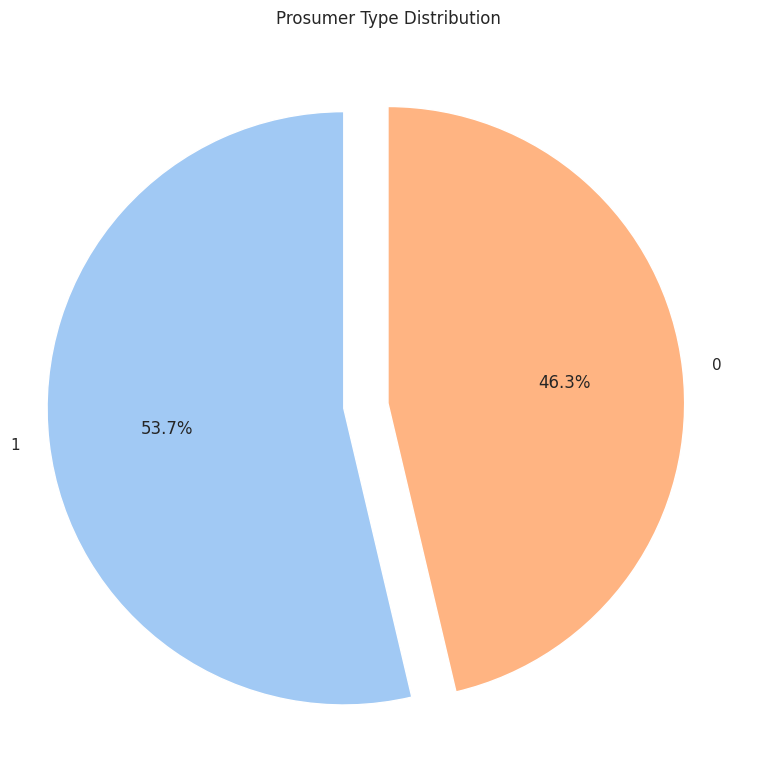

In [66]:
prosumer_type_counts = train_df['is_business'].value_counts()

# Define the explode parameter (e.g., pop out the first slice)
explode = [0.15 if i == 0 else 0 for i in range(len(prosumer_type_counts))]

plt.figure(figsize=(8, 8))
sns.set_palette("pastel")
plt.pie(prosumer_type_counts,
    labels=prosumer_type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode = explode, # with one slide exploded out
    # wedgeprops=dict(width=0.4) #This specifies that the width of each wedge should be 0.4 times the radius of the pie.
    )
plt.title('Prosumer Type Distribution')

plt.tight_layout()
plt.show()

### Correlation Heatmap

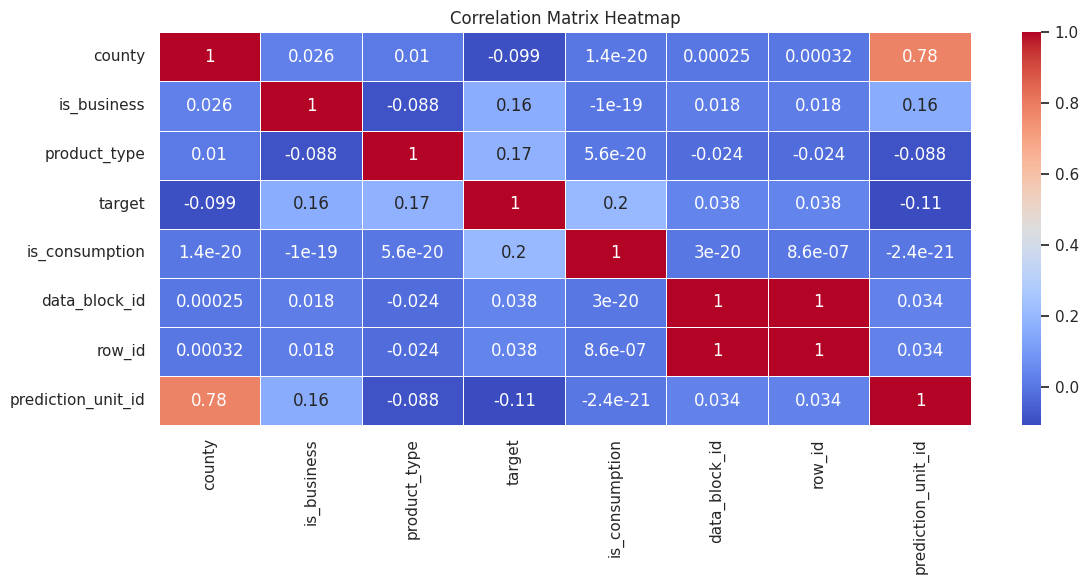

In [67]:
cols = [c for c in train_df.columns if c not in ["datetime", "date"]]

corr_matrix = train_df[cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix,
      annot=True,
      cmap='coolwarm',
      linewidths=0.5)

# Set the title
plt.title('Correlation Matrix Heatmap')

# Display the plot
plt.tight_layout()
plt.show()

### Gas Prices vs. Electricity Prices Over Time

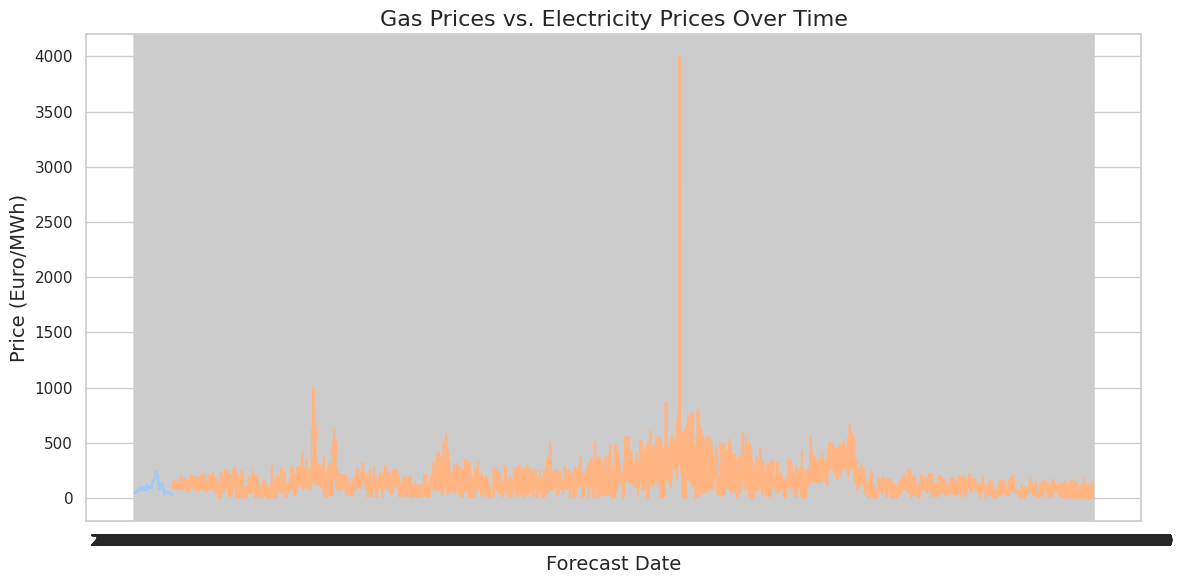

In [69]:
# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=gas_prices_df,
    x='forecast_date',
    y='lowest_price_per_mwh',
)
sns.lineplot(
    data=electricity_prices_df,
    x='forecast_date',
    y='euros_per_mwh',
)

plt.title('Gas Prices vs. Electricity Prices Over Time', fontsize=16)
plt.xlabel('Forecast Date', fontsize=14)
plt.ylabel('Price (Euro/MWh)', fontsize=14)

plt.tight_layout()
plt.show()

## Time Series Analysis